In [2]:
# 라이브러리 임포트

from google.cloud import bigquery
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

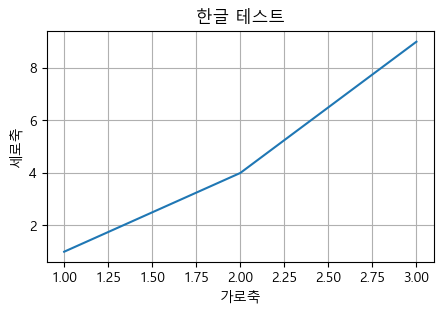

In [1]:
# 시각화 설정

import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 테스트
plt.figure(figsize=(5, 3))
plt.plot([1, 2, 3], [1, 4, 9])
plt.title("한글 테스트")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.grid(True)
plt.show()

In [3]:
# BigQuery 연결 설정

client = bigquery.Client()

PROJECT_ID = 'sesac-sd-bigquery-478605'  
DATASET = 'project'        

print(f"프로젝트: {PROJECT_ID}")
print(f"데이터셋: {DATASET}")

프로젝트: sesac-sd-bigquery-478605
데이터셋: project


In [4]:
# MBTI별 핵심 지표 종합

query = f"""
WITH user_stats AS (
    SELECT 
        u.user_id,
        u.mbti,
        u.mbti_e_i,
        u.mbti_s_n,
        u.mbti_t_f,
        u.mbti_j_p,
        u.is_churned,
        COUNT(DISTINCT s.session_id) as total_sessions,
        AVG(s.session_duration_sec) as avg_session_duration,
        SUM(s.page_views) as total_page_views,
        SUM(s.cart_additions) as total_cart_additions,
        SUM(CASE WHEN s.is_converted THEN 1 ELSE 0 END) as converted_sessions
    FROM `{PROJECT_ID}.{DATASET}.users` u
    LEFT JOIN `{PROJECT_ID}.{DATASET}.sessions` s ON u.user_id = s.user_id
    WHERE u.is_bot = FALSE AND (s.is_bot = FALSE OR s.is_bot IS NULL)
    GROUP BY u.user_id, u.mbti, u.mbti_e_i, u.mbti_s_n, u.mbti_t_f, u.mbti_j_p, u.is_churned
)
SELECT 
    mbti,
    COUNT(*) as user_count,
    ROUND(AVG(total_sessions), 1) as avg_sessions,
    ROUND(AVG(avg_session_duration), 0) as avg_duration_sec,
    ROUND(AVG(total_page_views), 1) as avg_page_views,
    ROUND(AVG(total_cart_additions), 1) as avg_cart_adds,
    ROUND(AVG(converted_sessions) * 100 / NULLIF(AVG(total_sessions), 0), 2) as session_cvr,
    ROUND(SUM(CASE WHEN is_churned THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as churn_rate
FROM user_stats
GROUP BY mbti
ORDER BY session_cvr DESC
"""

df_mbti_stats = client.query(query).to_dataframe()
df_mbti_stats

,mbti,user_count,avg_sessions,avg_duration_sec,avg_page_views,avg_cart_adds,session_cvr,churn_rate
0,ESTP,261,116.1,602.0,454.7,217.4,65.53,21.46
1,ESFP,403,122.1,1503.0,1314.1,705.0,12.31,22.08
2,ENFP,428,114.3,1322.0,1105.0,554.5,11.47,29.21
3,ISFP,325,101.8,1325.0,953.9,408.4,9.13,16.62
4,INFP,290,90.3,1505.0,888.0,329.9,8.23,19.66
5,ESFJ,429,113.8,1080.0,910.3,261.0,8.02,9.32
6,ENTP,247,110.7,1081.0,917.9,381.2,7.07,29.96
7,ENFJ,315,120.0,898.0,800.4,254.7,6.90,9.21
8,INTP,208,90.2,1206.0,835.1,256.8,4.44,19.23
9,ISFJ,399,85.2,959.0,586.1,115.1,4.19,6.27


In [5]:
# MBTI 유형명 매핑

mbti_names = {
    'INTJ': '전략가', 'INTP': '논리술사', 'ENTJ': '통솔자', 'ENTP': '변론가',
    'INFJ': '옹호자', 'INFP': '중재자', 'ENFJ': '선도자', 'ENFP': '활동가',
    'ISTJ': '현실주의자', 'ISFJ': '수호자', 'ESTJ': '경영자', 'ESFJ': '집정관',
    'ISTP': '장인', 'ISFP': '모험가', 'ESTP': '사업가', 'ESFP': '연예인'
}

df_mbti_stats['type_name'] = df_mbti_stats['mbti'].map(mbti_names)
df_mbti_stats[['mbti', 'type_name', 'user_count', 'avg_sessions', 'session_cvr', 'churn_rate']]

,mbti,type_name,user_count,avg_sessions,session_cvr,churn_rate
0,ESTP,사업가,261,116.1,65.53,21.46
1,ESFP,연예인,403,122.1,12.31,22.08
2,ENFP,활동가,428,114.3,11.47,29.21
3,ISFP,모험가,325,101.8,9.13,16.62
4,INFP,중재자,290,90.3,8.23,19.66
5,ESFJ,집정관,429,113.8,8.02,9.32
6,ENTP,변론가,247,110.7,7.07,29.96
7,ENFJ,선도자,315,120.0,6.90,9.21
8,INTP,논리술사,208,90.2,4.44,19.23
9,ISFJ,수호자,399,85.2,4.19,6.27


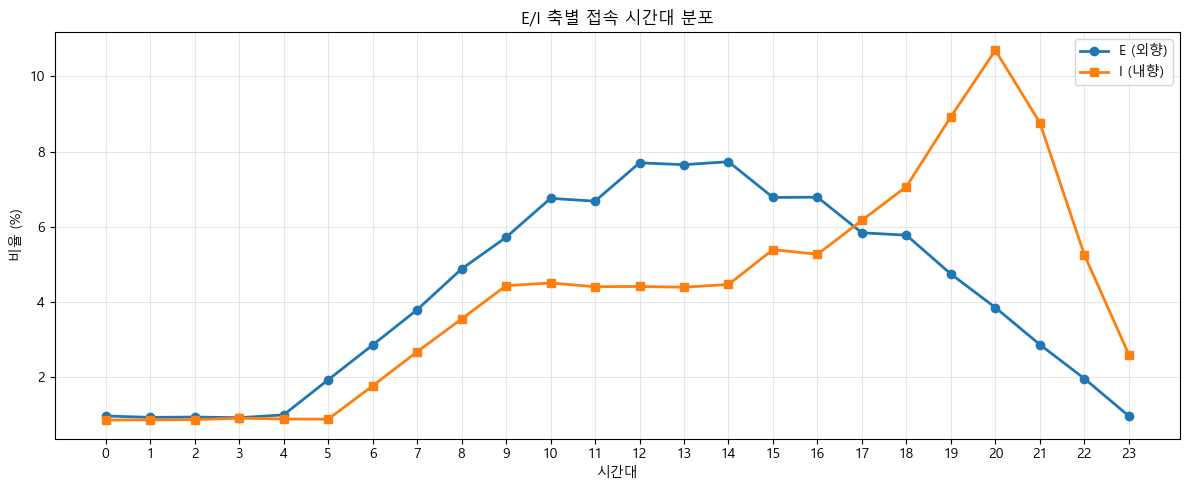

In [6]:
# E/I 축별 접속 시간대 분포

query = f"""
SELECT 
    u.mbti_e_i,
    EXTRACT(HOUR FROM TIMESTAMP(s.session_start)) as hour,
    COUNT(*) as session_count
FROM `{PROJECT_ID}.{DATASET}.sessions` s
JOIN `{PROJECT_ID}.{DATASET}.users` u ON s.user_id = u.user_id
WHERE s.is_bot = FALSE
GROUP BY u.mbti_e_i, hour
ORDER BY u.mbti_e_i, hour
"""

df_hour = client.query(query).to_dataframe()

# 피벗
df_hour_pivot = df_hour.pivot(index='hour', columns='mbti_e_i', values='session_count').fillna(0)

# 비율로 변환
df_hour_pivot['E_pct'] = df_hour_pivot['E'] / df_hour_pivot['E'].sum() * 100
df_hour_pivot['I_pct'] = df_hour_pivot['I'] / df_hour_pivot['I'].sum() * 100

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(df_hour_pivot.index, df_hour_pivot['E_pct'], marker='o', label='E (외향)', linewidth=2)
plt.plot(df_hour_pivot.index, df_hour_pivot['I_pct'], marker='s', label='I (내향)', linewidth=2)
plt.xlabel('시간대')
plt.ylabel('비율 (%)')
plt.title('E/I 축별 접속 시간대 분포')
plt.legend()
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

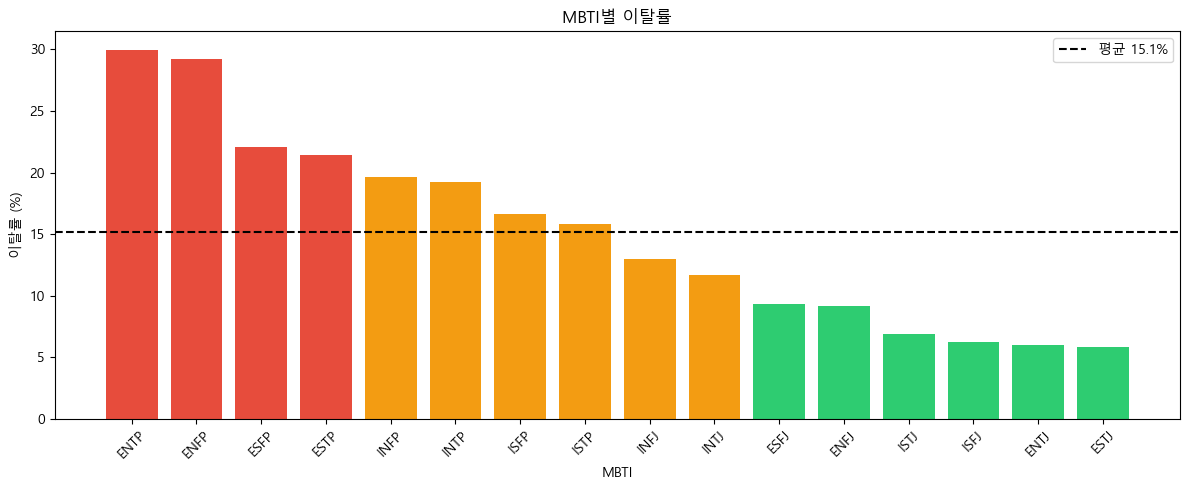

In [8]:
# MBTI별 이탈률 시각화

df_churn = df_mbti_stats.sort_values('churn_rate', ascending=False)

plt.figure(figsize=(12, 5))
colors = ['#e74c3c' if x > 20 else '#f39c12' if x > 10 else '#2ecc71' for x in df_churn['churn_rate']]
plt.bar(df_churn['mbti'], df_churn['churn_rate'], color=colors)
plt.axhline(y=df_churn['churn_rate'].mean(), color='black', linestyle='--', label=f"평균 {df_churn['churn_rate'].mean():.1f}%")
plt.title('MBTI별 이탈률')
plt.xlabel('MBTI')
plt.ylabel('이탈률 (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

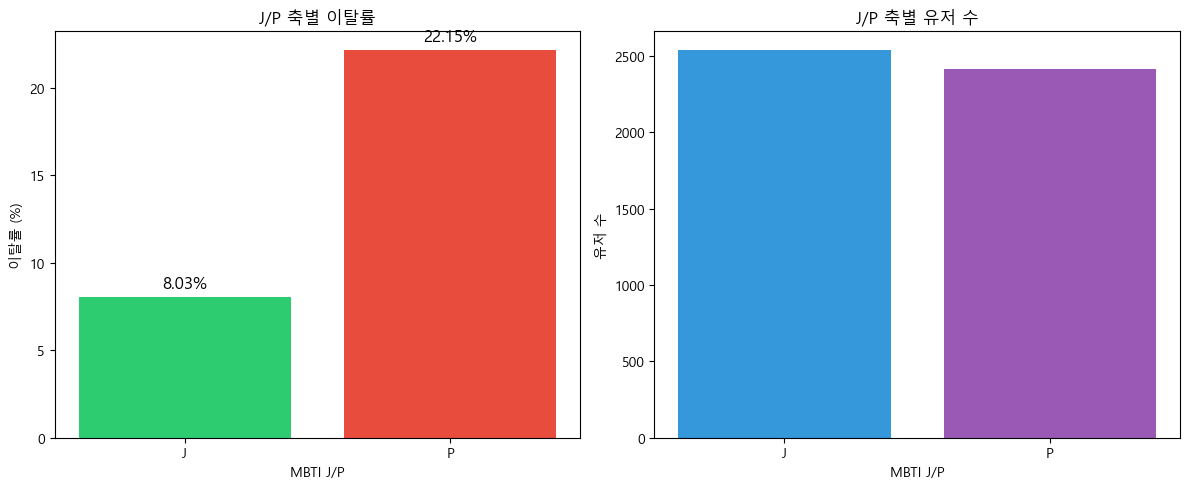

,mbti_j_p,total_users,churned_users,churn_rate
0,J,2539,204,8.03
1,P,2415,535,22.15


In [9]:
# J/P 축별 이탈률 비교

query = f"""
SELECT 
    u.mbti_j_p,
    COUNT(*) as total_users,
    SUM(CASE WHEN u.is_churned THEN 1 ELSE 0 END) as churned_users,
    ROUND(SUM(CASE WHEN u.is_churned THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as churn_rate
FROM `{PROJECT_ID}.{DATASET}.users` u
WHERE u.is_bot = FALSE
GROUP BY u.mbti_j_p
"""

df_jp_churn = client.query(query).to_dataframe()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 이탈률 비교
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(df_jp_churn['mbti_j_p'], df_jp_churn['churn_rate'], color=colors)
axes[0].set_title('J/P 축별 이탈률')
axes[0].set_xlabel('MBTI J/P')
axes[0].set_ylabel('이탈률 (%)')
for i, v in enumerate(df_jp_churn['churn_rate']):
    axes[0].text(i, v + 0.5, f'{v}%', ha='center', fontsize=12)

# 유저 수 비교
axes[1].bar(df_jp_churn['mbti_j_p'], df_jp_churn['total_users'], color=['#3498db', '#9b59b6'])
axes[1].set_title('J/P 축별 유저 수')
axes[1].set_xlabel('MBTI J/P')
axes[1].set_ylabel('유저 수')

plt.tight_layout()
plt.show()

df_jp_churn

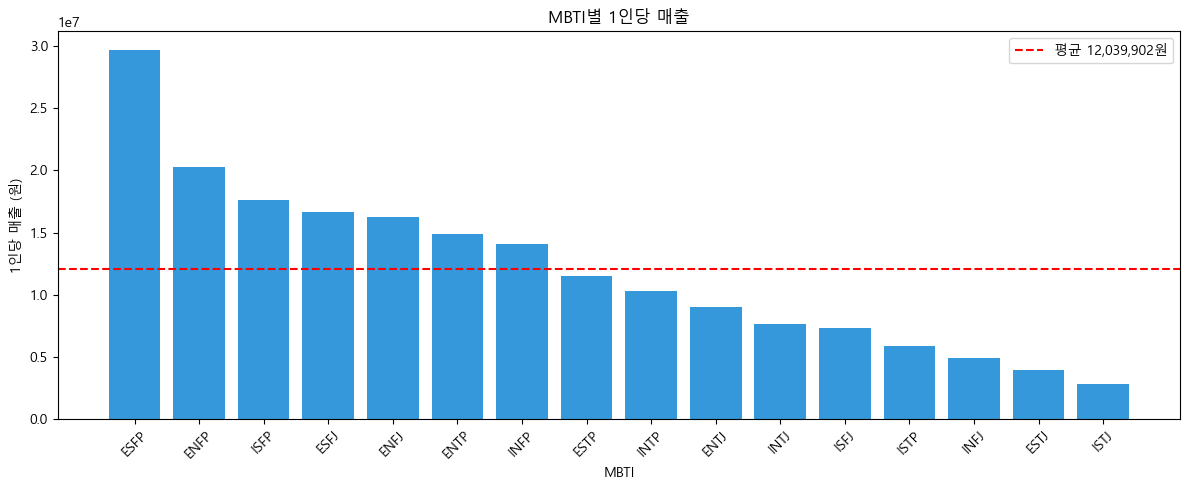

,mbti,type_name,total_orders,avg_order_amount,revenue_per_user
0,ESFP,연예인,48152,248534.0,29695762.0
1,ENFP,활동가,44492,195190.0,20290669.0
2,ISFP,모험가,31953,178981.0,17596903.0
3,ESFJ,집정관,47405,150520.0,16632676.0
4,ENFJ,선도자,34727,147139.0,16221212.0
5,ENTP,변론가,21704,169240.0,14871183.0
6,INFP,중재자,25406,160527.0,14063271.0
7,ESTP,사업가,35106,85389.0,11485302.0
8,INTP,논리술사,15400,138803.0,10276756.0
9,ENTJ,통솔자,19527,116068.0,9029712.0


In [10]:
# MBTI별 평균 구매액

query = f"""
SELECT 
    u.mbti,
    COUNT(DISTINCT o.order_id) as total_orders,
    ROUND(AVG(o.total_amount), 0) as avg_order_amount,
    ROUND(SUM(o.total_amount) / COUNT(DISTINCT u.user_id), 0) as revenue_per_user
FROM `{PROJECT_ID}.{DATASET}.users` u
LEFT JOIN `{PROJECT_ID}.{DATASET}.orders` o ON u.user_id = o.user_id
WHERE u.is_bot = FALSE
GROUP BY u.mbti
ORDER BY revenue_per_user DESC
"""

df_revenue = client.query(query).to_dataframe()
df_revenue['type_name'] = df_revenue['mbti'].map(mbti_names)

# 시각화
plt.figure(figsize=(12, 5))
plt.bar(df_revenue['mbti'], df_revenue['revenue_per_user'], color='#3498db')
plt.axhline(y=df_revenue['revenue_per_user'].mean(), color='red', linestyle='--', label=f"평균 {df_revenue['revenue_per_user'].mean():,.0f}원")
plt.title('MBTI별 1인당 매출')
plt.xlabel('MBTI')
plt.ylabel('1인당 매출 (원)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

df_revenue[['mbti', 'type_name', 'total_orders', 'avg_order_amount', 'revenue_per_user']]